<a href="https://colab.research.google.com/github/teerasitk/Remote-Sensing-Assignments/blob/main/Assignment02_ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Work with Google Earth Engine

 ### 1. Load library and initialize Google Earth Engine

In [ ]:
import ee
ee.Authenticate()
ee.Initialize()
import numpy as np
import matplotlib.pyplot as plt

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=FfXroZPHfl8rzt7xSppdkLgBofbfzqr79pJZ4GCwgKA&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWgvtAlA1n5gb5up3gWI50OiSJGcxSK46f9TIyBF_HGrtyV0c4z296E

Successfully saved authorization token.


### 2. Build the display function for land cover map and image

In [ ]:
import folium
def showLC(image, lc_label, aoi, num_classes, palette=None, zoom=15):
  xc, yc =  aoi.centroid().getInfo()['coordinates']
  aoi_map = folium.Map(location=[yc, xc], zoom_start=zoom)
  basemaps = {'Google Maps': folium.TileLayer(
    tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',  #google map service site
    attr = 'Google',
    name = 'Google Maps',
    overlay = True,
    control=True)} # tell folium that the base map is the google map.
  basemaps['Google Maps'].add_to(aoi_map) # add google earth data into ku_map
  im_clib = image.clip(aoi)
  if  palette is None:
     palette = ['006400' ,'ffbb22', 'ffff4c', 'f096ff', 'fa0000', 'b4b4b4',
                'f0f0f0', '0064c8', '0096a0', '00cf75', 'fae6a0']
  viz_params = {'bands':[lc_label],
                'min': 0,
                'palette': palette,
                'max':num_classes}
  map_obj = im_clib.getMapId(viz_params) # convert image into map object

  folium.TileLayer(
      tiles=map_obj ['tile_fetcher'].url_format, #item where the image is linked to
      overlay=True,
      attr='Original Image',
      name=f'False Color Composite',
    ).add_to(aoi_map)
  return aoi_map

def showImageOnMap(image, bands, aoi, min_val, max_val, zoom=15):
  xc, yc =  aoi.centroid().getInfo()['coordinates']
  aoi_map = folium.Map(location=[yc, xc], zoom_start=zoom)
  basemaps = {'Google Maps': folium.TileLayer(
    tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',  #google map service site
    attr = 'Google',
    name = 'Google Maps',
    overlay = True,
    control=True)} # tell folium that the base map is the google map.
  basemaps['Google Maps'].add_to(aoi_map) # add google earth data into ku_map
  im_clib = image.clip(aoi)
  viz_params = {'bands':bands, 'min': min_val,
                'max': max_val}
  map_obj = im_clib.getMapId(viz_params) # convert image into map object

  folium.TileLayer(
      tiles=map_obj ['tile_fetcher'].url_format, #item where the image is linked to
      overlay=True,
      attr='Original Image',
      name=f'False Color Composite',
    ).add_to(aoi_map)
  return aoi_map
def getNewBandNames(prefix, num):
  return [f"{prefix}{k}" for k in range(num)]
def normalizeAllBand(image, aoi):
  img_band_names = image.bandNames().getInfo()
  imout = None
  for band in img_band_names:
    imb = image.select(band)
    min_max = imb.reduceRegion(ee.Reducer.percentile([2,98]),
                               geometry=aoi)#.getIngo()
    print(min_max.getInfo())
    imb = imb.unitScale(min_max.get(band+'_p2'), min_max.get(band+'_p98'))
    if imout is None:
      imout = imb
    else:
      imout = imout.addBands(imb)
  return imout

### 3. Set the area of interest (AOI)

In [ ]:
aoi = ee.Geometry.Polygon([ [ 99.776796700071003, 17.064532089073847 ],
                           [ 99.821638573909041, 17.079199991731151 ],
                           [ 99.870671277077747, 17.06620842080611 ],
                           [ 99.86710907214669, 16.987211287923198 ],
                           [ 99.774282202472605, 16.983858624458673 ],
                           [ 99.776796700071003, 17.064532089073847 ] ])

### 4. Load a single date Image

In [ ]:
from datetime import datetime
img = ee.ImageCollection('COPERNICUS/S2_SR')
img = img.filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10)).filterDate('2019-11-01','2019-12-01')
img = img.select("B.*")
img = img.filterBounds(aoi).first()
date = img.getInfo()['properties']["system:time_start"]
date = date_time_obj = datetime.fromtimestamp(date/1000.0)
datetxt = date.strftime('%Y-%m-%d')
print(f"Image was captured on {datetxt}")
img = img.multiply(0.0001)

Image was captured on 2019-11-11


### 5. Display an image

In [ ]:
im_map = showImageOnMap(img, ["B8","B4", "B3"],aoi, min_val=0, max_val=0.5, zoom=14)
im_map

### 6. Load Ground data from ESA WorldCover 10m v100 dataset

In [ ]:
dataset = ee.ImageCollection("ESA/WorldCover/v100").first()
date = dataset .getInfo()['properties']["system:time_start"]
date = date_time_obj = datetime.fromtimestamp(date/1000.0)
datetxt = date.strftime('%Y-%m-%d')
print(f"Dataset was creted on {datetxt}")
remap_values = ee.List([0, 1,1, 2, 3, 4, 4, 5, 4, 4, 4])
label = "landcover"
legend = ['Trees', 'Shrubland-Grassland', 'Cropland', 'Built-up', 'Barren / sparse vegetation', 'Open water']
palette = ['006400' ,'00FA00', 'ffff4c', 'fa0000', 'f000f0', '0000fa']
class_values = ee.List([10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100])
dataset = dataset.remap(class_values, remap_values).rename(label).toByte()

Dataset was creted on 2020-01-01


### 7. Display the ground data where
- Dark Green: Trees
- Light Green: Shrubland and Grassland
- Yellow: Cropland
- Red: Built-up
- Purple: Barren / sparse vegetation
- Blue: Open Water


In [ ]:
lc_map = showLC(dataset, label, aoi, 5, zoom=14, palette=palette)
lc_map

### 8. Take 100 samples per class

In [ ]:
sample = img.addBands(dataset).stratifiedSample(numPoints=100,
                                                classBand=label,
                                                region=aoi,
                                                scale=10,
                                                geometries=True)

### 9. Check how many samples that we can actually collected

In [ ]:
for cl, name in enumerate(legend):
  num = sample.filter(f'landcover=={cl}').aggregate_count("landcover").getInfo()
  print(f"Sample Class {name}: {num}")

Sample Class Trees: 100
Sample Class Shrubland-Grassland: 100
Sample Class Cropland: 100
Sample Class Built-up: 100
Sample Class Barren / sparse vegetation: 100
Sample Class Open water: 100


### 10. Make 70% Train and 30% Test Samples

In [ ]:
sample = sample.randomColumn()
trainingSample = sample.filter('random <= 0.7')
validationSample = sample.filter('random > 0.7')

### 11. Build Support Vector Machine with RBF kernel function with $\gamma=5$

$\phi(u,v)= e^{-\gamma|u-v|^2}$

and penalty $C=100$

In [ ]:
trainedClassifier = ee.Classifier.libsvm(kernelType="RBF",gamma=5,cost=100)
trainedClassifier = trainedClassifier.train(features=trainingSample,
                                            classProperty=label,
                                            inputProperties=img.bandNames())

### 12. Check on the description of the classifier

In [ ]:
trainedClassifier.explain().getInfo()

{'classes': [0, 1, 2, 3, 4, 5],
 'svm_parameters': {'C': 100,
  'coef0': 0,
  'degree': 0,
  'eps': 0.001,
  'gamma': 5,
  'kernel_type': 'RBF',
  'nu': 0.5,
  'p': 0.1,
  'probability': 0,
  'shrinking': 1,
  'svm_type': 'C_SVC'}}

### 13. Obtain confusion matrix on both train and validation samples

In [ ]:
train_conf_mat = np.array(trainedClassifier.confusionMatrix().getInfo())
validationResult = validationSample.classify(trainedClassifier)
validation_conf_mat = np.array(validationResult.errorMatrix(label, 'classification').getInfo())

Confusion matrix for Train Samples

In [ ]:
print(train_conf_mat)

[[52  7  3  2  3  0]
 [ 6 51  7  0  6  0]
 [ 6  1 56  2  7  0]
 [ 5  0  0 65  8  0]
 [ 7  7  8  7 44  0]
 [ 0  0  0  0  2 68]]


Confusion matrix for validation Samples

In [ ]:
print(validation_conf_mat)

[[15  3  6  3  6  0]
 [ 5 17  4  0  3  1]
 [ 5  4 16  0  3  0]
 [ 1  1  1 17  2  0]
 [ 6  3  9  4  5  0]
 [ 0  2  0  1  1 26]]


#### 12.1 Compute OA, Kappa, and Producers and Users' accuracies on Train

In [ ]:
def evaluteReport(conf_mat, legend=None):
  diag_conf_mat = np.diag(conf_mat)
  N = conf_mat.sum()
  N_ref = conf_mat.sum(0)
  N_map  = conf_mat.sum(1)
  pc = diag_conf_mat.sum()/ N
  ua = diag_conf_mat/ N_map
  pa = diag_conf_mat/ N_ref
  pe = (N_map * N_ref).sum() / (N**2)
  kappa = (pc - pe)/(1-pe)
  print(f"OA: {pc:0.3f} with Kappa: {kappa:0.3f}")
  if legend is None:
    legend = np.arange(conf_mat.shape[0])
  for k, name in enumerate(legend):
    print(f"PA[{name}]: {pa[k]:0.3f}, UA[{name}]: {ua[k]:0.3f}")
  return pc, kappa, ua, pa

Evaluate on train samples

In [ ]:
_ = evaluteReport(train_conf_mat, legend)

OA: 0.781 with Kappa: 0.738
PA[Trees]: 0.684, UA[Trees]: 0.776
PA[Shrubland-Grassland]: 0.773, UA[Shrubland-Grassland]: 0.729
PA[Cropland]: 0.757, UA[Cropland]: 0.778
PA[Built-up]: 0.855, UA[Built-up]: 0.833
PA[Barren / sparse vegetation]: 0.629, UA[Barren / sparse vegetation]: 0.603
PA[Open water]: 1.000, UA[Open water]: 0.971


#### 12.2 Compute OA, Kappa, and Producers and Users' accuracies on Validation Samples

In [ ]:
_ = evaluteReport(validation_conf_mat, legend)

OA: 0.565 with Kappa: 0.477
PA[Trees]: 0.469, UA[Trees]: 0.455
PA[Shrubland-Grassland]: 0.567, UA[Shrubland-Grassland]: 0.567
PA[Cropland]: 0.444, UA[Cropland]: 0.571
PA[Built-up]: 0.680, UA[Built-up]: 0.773
PA[Barren / sparse vegetation]: 0.250, UA[Barren / sparse vegetation]: 0.185
PA[Open water]: 0.963, UA[Open water]: 0.867


By comparing the results from train and validation samples, we observed that accuracies on both samples are quite similar excepts on Barren / sparse vegetatio Class.

However, the validation accuracies seems to be smaller than those on the train samples.

### 13. Display the resulting land cover map

In [ ]:
imgClassified = img.classify(trainedClassifier);
lc_map = showLC(imgClassified, "classification", aoi, 5, zoom=14, palette=palette)
lc_map

### 14. Let evaluate on the test samples

In [ ]:
test_sample = img.addBands(dataset).sample(numPixels=1000,    # get another 1000 test samples
                                           region=aoi,
                                           scale=10,
                                           geometries=True)
for cl, name in enumerate(legend):
  num = test_sample.filter(f'landcover=={cl}').aggregate_count("landcover").getInfo()
  print(f"Sample Class {name}: {num}") # how many samples per class
test_result = test_sample.classify(trainedClassifier)
test_conf_mat = np.array(test_result.errorMatrix(label, 'classification').getInfo())
_ = evaluteReport(test_conf_mat, legend)

Sample Class Trees: 128
Sample Class Shrubland-Grassland: 36
Sample Class Cropland: 557
Sample Class Built-up: 110
Sample Class Barren / sparse vegetation: 101
Sample Class Open water: 68
OA: 0.582 with Kappa: 0.434
PA[Trees]: 0.366, UA[Trees]: 0.469
PA[Shrubland-Grassland]: 0.176, UA[Shrubland-Grassland]: 0.639
PA[Cropland]: 0.882, UA[Cropland]: 0.576
PA[Built-up]: 0.662, UA[Built-up]: 0.818
PA[Barren / sparse vegetation]: 0.234, UA[Barren / sparse vegetation]: 0.317
PA[Open water]: 0.824, UA[Open water]: 0.824


From the test and validation results, we found that the accuracies on the train samples are low.  

# Assignment 1
Let us try to improve the accuracies by increasing the number of samples to 1,000 per class.

Report on Train, Validation and Test Accuracies

In [ ]:
# You code is here

## Result for 1,000 samples:__________.
What is your obsevation after increasing the number of samples

# Assignment 2

Maybe the poor accuracies on the test samples are due to the fact that we employed the inferior classifier. In this examples, we will use a more sophisticated classifier, namely, the Random Forest. To initialize the Random Forest we will write
stateOfTheArtClassifier = ee.Classifier.smileRandomForest(100, maxNodes=1024).
Try the new classifier with 1000 samples

In [ ]:
# You code is here

Report your results on train, validation, and test samples

# Assignment 3

From the results on Assignment 2, you will see that there are big gaps between train and validation accuracies. This phenomenal is called **Overfitting** problem. The remedy to this problem can be one of combination of these strategies.

1. Increse the number of samples
2. Reduce the number of features
3. Find better feature vectors.

In this assignment, we will first try to reduce the number of features
Here, we will use only "B2", "B3", "B4", and "B8"

In [ ]:
# You code is here

From the results, it is clear that the gap between train and validation accuracy reduces when the number of feature reduces. However, both train, validatin, and test accuracies also decrease.

# Assignment 4

Let us try to incorporate images from different dates, since crop and tree should have different temporal profile. We will use data from every one. One per month. Here, we will use all spectral bands, and increase the number of training samples to be 10,000 samples per class.

In [ ]:
# code to stack all images into a composite one
img = ee.ImageCollection('COPERNICUS/S2_SR')
img = img.filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20)).filterBounds(aoi)
imstack = None
for month in range(1,13):
  str_m = f"{month:02d}"
  date0 = ee.Date(f'2019-{str_m}-01')
  date1 = date0.advance(1, "month")
  img_month = img.filterDate(date0,date1)
  img_month = img_month.select("B.*")#.select(["B2", "B3", "B4", "B8"])#.select("B.*")#.select(["B2", "B3", "B4", "B8"])
  if img_month.size().getInfo() > 0:
    print(f"We have image on Month {month}")
    img_month = img_month.first()
    if imstack is None:
      imstack = img_month
    else:
      imstack = imstack.addBands(img_month )

imstack = imstack.multiply(0.0001)
print(imstack.bandNames().getInfo())

We have image on Month 1
We have image on Month 2
We have image on Month 3
We have image on Month 4
We have image on Month 5
We have image on Month 7
We have image on Month 9
We have image on Month 10
We have image on Month 11
We have image on Month 12
['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'B1_1', 'B2_1', 'B3_1', 'B4_1', 'B5_1', 'B6_1', 'B7_1', 'B8_1', 'B8A_1', 'B9_1', 'B11_1', 'B12_1', 'B1_2', 'B2_2', 'B3_2', 'B4_2', 'B5_2', 'B6_2', 'B7_2', 'B8_2', 'B8A_2', 'B9_2', 'B11_2', 'B12_2', 'B1_3', 'B2_3', 'B3_3', 'B4_3', 'B5_3', 'B6_3', 'B7_3', 'B8_3', 'B8A_3', 'B9_3', 'B11_3', 'B12_3', 'B1_4', 'B2_4', 'B3_4', 'B4_4', 'B5_4', 'B6_4', 'B7_4', 'B8_4', 'B8A_4', 'B9_4', 'B11_4', 'B12_4', 'B1_5', 'B2_5', 'B3_5', 'B4_5', 'B5_5', 'B6_5', 'B7_5', 'B8_5', 'B8A_5', 'B9_5', 'B11_5', 'B12_5', 'B1_6', 'B2_6', 'B3_6', 'B4_6', 'B5_6', 'B6_6', 'B7_6', 'B8_6', 'B8A_6', 'B9_6', 'B11_6', 'B12_6', 'B1_7', 'B2_7', 'B3_7', 'B4_7', 'B5_7', 'B6_7', 'B7_7', 'B8_7', 'B8A_7', 'B9_

Take 10,000 samples per classe

In [ ]:
sample = imstack.addBands(dataset).stratifiedSample(numPoints=10000,
                                                    classBand=label,
                                                    region=aoi,
                                                    scale=10,
                                                    geometries=True)

 70% train 30%Test

In [ ]:
sample = sample.randomColumn()
trainingSample = sample.filter('random <= 0.7')
validationSample = sample.filter('random > 0.7')

Evaluate train, validate and test data

In [ ]:
# your code here


# Work with high resolution Image

In this exercise, we will integrate the unsupervised and supervised classification for LC on high resolution image.

### 1. Upload top_mosaic_09cm_area17.tif and gt_top_mosaic_09cm_area17.tif

### 2. Use Gdal library to read both image and ground data

In [ ]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
im = gdal.Open("/content/top_mosaic_09cm_area17.tif")
data = im.ReadAsArray().transpose([1,2 ,0])
gt = gdal.Open("/content/gt_top_mosaic_09cm_area17.tif")
gt_data = gt.ReadAsArray().transpose([1, 2, 0])

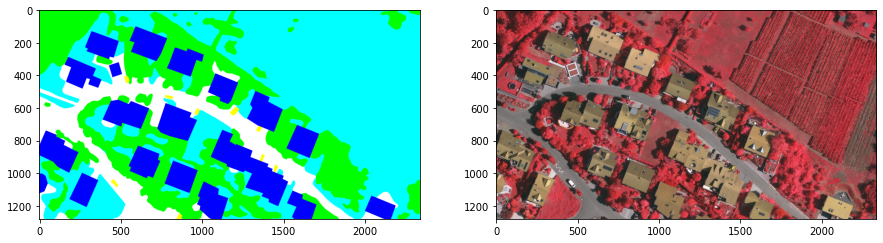

In [ ]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(gt_data)
plt.subplot(1,2,2)
plt.imshow(data)

We observe that the class of "car" has very limited number of pixels where grass, tress and builds cover the large area.

### 3. Change color in ground data into class lables.

In [ ]:
np.unique(gt_data.reshape(-1,3), axis=0)

array([[  0,   0, 255],
       [  0, 255,   0],
       [  0, 255, 255],
       [255, 255,   0],
       [255, 255, 255]], dtype=uint8)

In [ ]:
color_dict = {'building':([0,0,255], 0),
              'vegetation':([0,255,0], 1),
              'grass':([0, 255,255], 2),
              'car':([255,255,0],3),
              'pavement':([255,255,255],4)}


Convert color ground data into gray-scale image

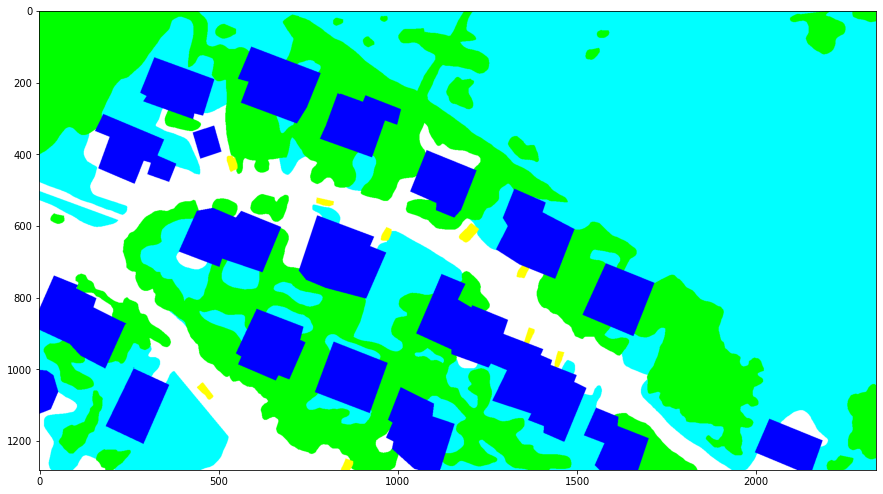

In [ ]:
n_rows, n_cols,_ = gt_data.shape
gt_gray = np.zeros((n_rows, n_cols), "uint8")
color_list = []
for k, (name, info) in enumerate(color_dict.items()):
  value, label = info
  indx = None
  color_list.append(value)
  for b in range(3):
    if indx is None:
      indx = (gt_data[:, :, b]==value[b])
    else:
      indx &= (gt_data[:, :, b]==value[b])
  gt_gray[indx] = label
color_list = np.array(color_list)
plt.figure(figsize=(15,10))
plt.imshow(color_list[gt_gray])

### 4. take stratified random samples

In [ ]:
def stratifiedRandomSampling(num_samples, image, ground_data):
  x = None
  y = None
  num_classes = ground_data.max() + 1
  if image.ndim == 3:
    n_rows, n_cols,n_bands = image.shape
    im1d = image.reshape((-1, n_bands))
  else:
    im1d = image
  gt1d = ground_data.flatten()
  for cls in range(num_classes):
    idx = np.nonzero(gt1d==cls)[0]
    id_rand = np.random.permutation(idx)[:num_samples]
    if x is None:
      x = im1d[id_rand,:]
      y = np.zeros((len(id_rand),), 'uint8')+ cls
    else:
      xp = im1d[id_rand,:]
      yp = np.zeros((len(id_rand),), 'uint8') + cls
      x = np.concatenate((x, xp), axis=0)
      y = np.concatenate((y, yp))
  idx = np.random.permutation(len(y))
  print(x.shape, y.shape)
  x = x[idx,:]
  y = y[idx]
  return x,y

#### obtain 500 samples per class

In [ ]:
x,y = stratifiedRandomSampling(num_samples=500, image=data, ground_data=gt_gray)

(2500, 3) (2500,)


### 5. make train and test sample using sklearn library

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

### 6. Perform pixel-wise classificaiton using Random Forest classifier with 200 trees with maximum depth of 5.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
clf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=0)
clf.fit(x_train, y_train)
print(f"Train Accuracy: {clf.score(x_train, y_train):0.3f}")
print(f"Test Accuracy: {clf.score(x_test, y_test):0.3f}")

Train Accuracy: 0.684
Test Accuracy: 0.628


From the accuracy result, the classifier is overfitted!!!

### 7. perform land cover mapping on the entire scene

In [ ]:
data1d = data.reshape(-1,3)
lc_map = clf.predict(data1d)
lc_map = lc_map.reshape(n_rows, n_cols)

### 8. Display the result

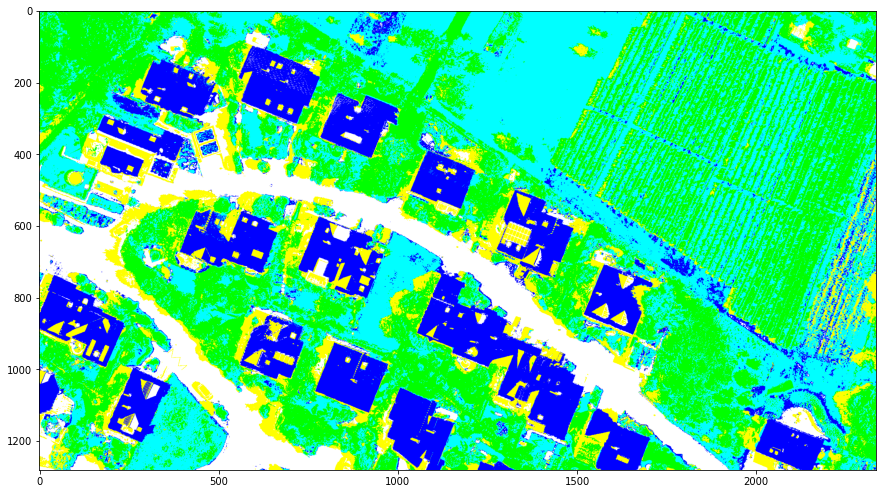

In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(color_list[lc_map])

### 9. Evaluate the peformance

In [ ]:
legend_high_res = list(color_dict.keys())

In [ ]:
from sklearn.metrics import confusion_matrix
conf_train = confusion_matrix(y_train, clf.predict(x_train))
conf_valid = confusion_matrix(y_test, clf.predict(x_test))
conf_whole =  confusion_matrix(gt_gray.flatten(), lc_map.flatten())
legend_high_res = list(color_dict.keys())
print("TRAIN SAMPLES")
_ = evaluteReport(conf_train.T, legend_high_res)
print("TEST SAMPLES")
_ = evaluteReport(conf_valid.T, legend_high_res)
print("WHOLE IMAGE")
_ = evaluteReport(conf_whole.T, legend_high_res)

TRAIN SAMPLES
OA: 0.684 with Kappa: 0.604
PA[building]: 0.776, UA[building]: 0.808
PA[vegetation]: 0.695, UA[vegetation]: 0.632
PA[grass]: 0.574, UA[grass]: 0.660
PA[car]: 0.691, UA[car]: 0.580
PA[pavement]: 0.681, UA[pavement]: 0.777
TEST SAMPLES
OA: 0.628 with Kappa: 0.535
PA[building]: 0.781, UA[building]: 0.763
PA[vegetation]: 0.598, UA[vegetation]: 0.584
PA[grass]: 0.521, UA[grass]: 0.564
PA[car]: 0.619, UA[car]: 0.535
PA[pavement]: 0.620, UA[pavement]: 0.710
WHOLE IMAGE
OA: 0.625 with Kappa: 0.493
PA[building]: 0.789, UA[building]: 0.817
PA[vegetation]: 0.653, UA[vegetation]: 0.528
PA[grass]: 0.526, UA[grass]: 0.764
PA[car]: 0.655, UA[car]: 0.018
PA[pavement]: 0.694, UA[pavement]: 0.775


### 10. Let us integrate the clustering algorithm with the supervised classification by performning superpixel clustering using SEEDS algorithm for $N=1000$ super-pixels.

Text(0.5, 1.0, 'K=1000')

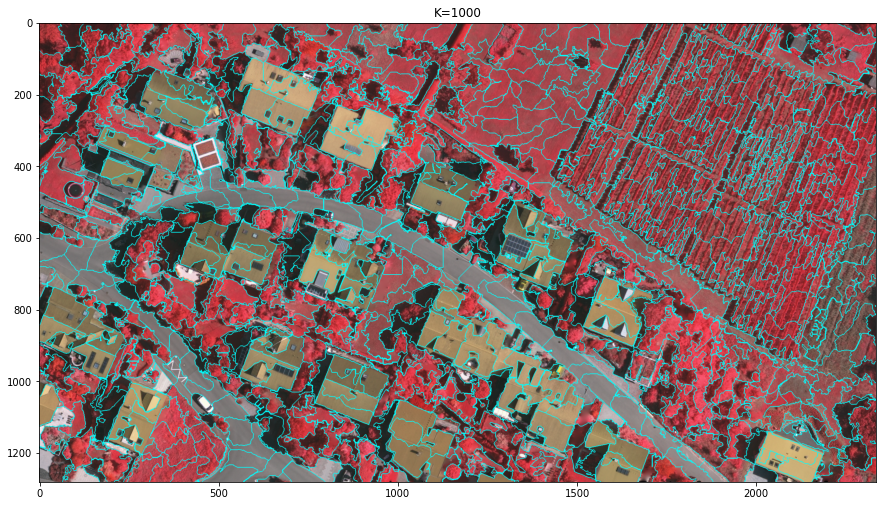

In [ ]:
import cv2
num_pixels = data.shape[0]  * data.shape[1]
num_sub_pixels = 1000
seeds = cv2.ximgproc.createSuperpixelSEEDS(data.shape[1],
                                           data.shape[0],
                                           data.shape[2],
                                           num_superpixels=num_sub_pixels,
                                           num_levels=5)

seeds.iterate(data, 500)
mask = seeds.getLabelContourMask(thick_line=True)
mask = mask[:,:,np.newaxis]
dat2 = (mask==255)*np.array([[0,255,255]]) + (mask==0)*data
plt.figure(figsize=(15,10))
plt.imshow(dat2)
plt.title(f"K={num_sub_pixels}")

### 11. Obtain superpixel lables

In [ ]:
spxl_im = seeds.getLabels()
print(np.unique(spxl_im))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

### 12. Convert superpixel into feature vector. Here, we extract band-wise mean and standard deviation. For one superpixel, we hav3 values (3 for means)

In [ ]:
from scipy import stats
spxl_im1d = spxl_im.flatten()
data1d = data.reshape(-1,3)
gt_gray_1d = gt_gray.flatten()
features =[]
spxl_labels = []
for val in np.unique(spxl_im1d):
  patch = data1d[spxl_im1d==val,:]
  lb_patch = gt_gray_1d[spxl_im1d==val]
  mode = stats.mode(lb_patch)
  spxl_labels.append(mode[0][0])
  #ft = [np.concatenate((patch.mean(0), patch.std(0)))]
  ft= patch.mean(0)
  features.append(ft)
features = np.array(features).reshape(-1,3)
spxl_labels = np.array(spxl_labels)

### 13. Due to limited number of super pixels, we use 20% for train and 80% for test

In [ ]:
xsp,ysp = stratifiedRandomSampling(num_samples=20, image=features, ground_data=spxl_labels)

(80, 3) (80,)


### 14. Here, we employed the k-nearest neighbors with neighbor size of 7.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knnmodel = KNeighborsClassifier(n_neighbors=7)
knnmodel.fit(xsp, ysp)

KNeighborsClassifier(n_neighbors=7)

### 15. Perform classification on superpixels and put the labels into the image

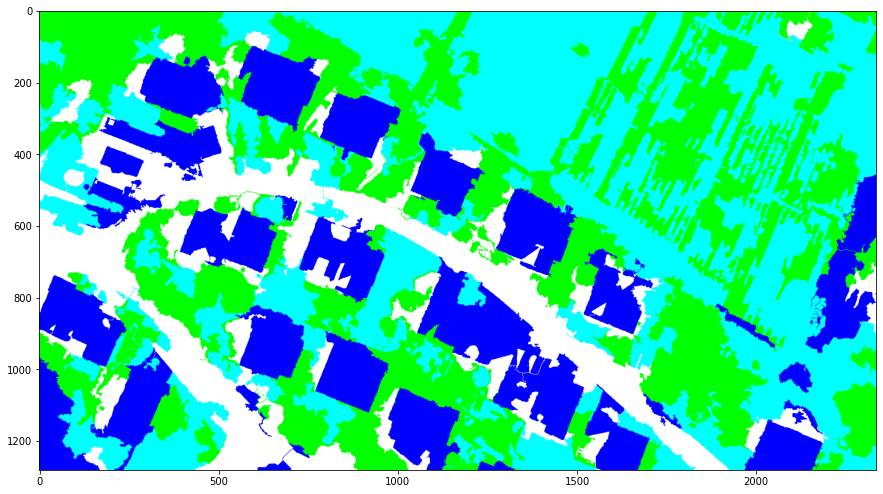

In [ ]:
sp_map = knnmodel.predict(features)
lc_map2 = np.zeros((n_rows, n_cols), 'uint8')
for k,val in enumerate(np.unique(spxl_im1d)):
  lc_map2[spxl_im==val] = sp_map[k]
plt.figure(figsize=(15,10))
plt.imshow(color_list[lc_map2])

### 16. Compare between different approaches

Text(0.5, 1.0, 'Superpixel Classification')

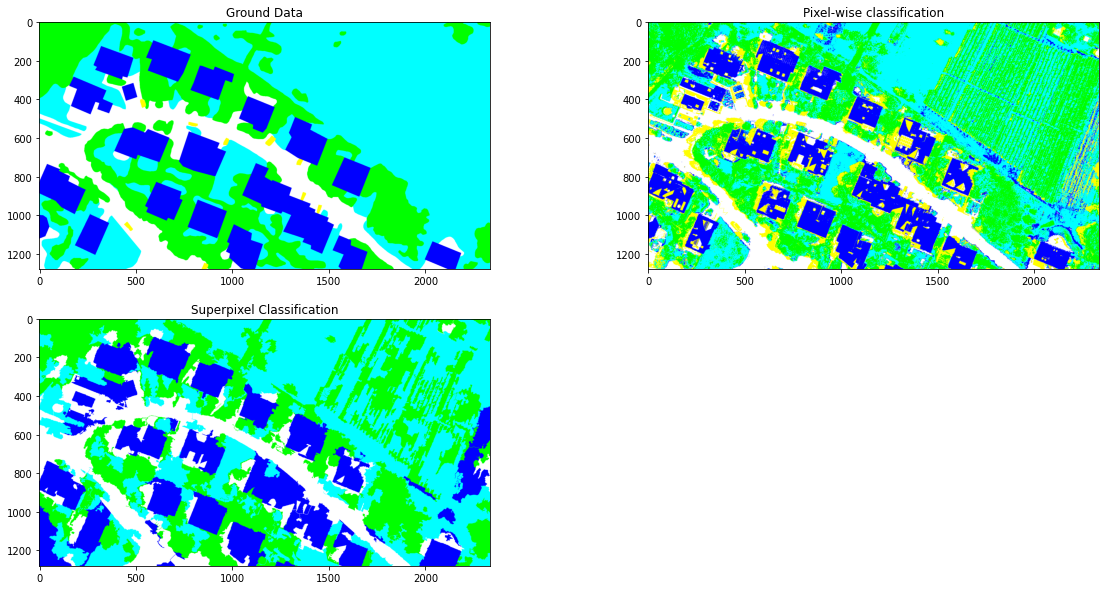

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.imshow(color_list[gt_gray])
plt.title("Ground Data")
plt.subplot(2,2,2)
plt.imshow(color_list[lc_map])
plt.title("Pixel-wise classification")
plt.subplot(2,2,3)
plt.imshow(color_list[lc_map2])
plt.title("Superpixel Classification")

# Assignment 5
Compare the accuracies (Overall, User's, Producers' accuracies) of superpixel classification againts pixelwise approach. Which one is better?

In [ ]:
# Your code

# Assignment 6
Repeat the superpixel classification with $N=10,000$ superpixels with 250 training pixels per class.

Between $N=1,000$ and $N=10,000$ super-pixels which one perform better?

In [ ]:
# your code

# Assignment 7
Repeat the superpixel classification with $N=10,000$ superpixels with 250 training pixels per class with Random Forest Classifier with the same parameter with pixelwise.

Compare between K-nearest neighbor and Random Forest. Which one has higer accuracy?

In [ ]:
# your code